# Import packages and functions

In [1]:
import sys
# force the notebook to look for files in the upper level directory
sys.path.insert(1, '../')

In [2]:
import pandas as pd
import seaborn as sns
from data.data_cleaning import remove_nullrows, knn_imputation, abbreviate_features, remove_redundant_features

# Define Path Constants

In [3]:
RAW_PATH = "../data/unprocessed/IMT_Classification_Dataset_Raw_Feature_Set_v10.xlsx"
SAVE_PATH = "../data/processed/IMT_Classification_Dataset_Full_Feature_Set_v10.xlsx"

# Exploratory Data Analysis

## 1. Read in the [unprocessed dataset](https://github.com/rpw199912j/mit_model_code/blob/master/data/unprocessed/IMT_Classification_Dataset_matminer_and_handbuilt_v9.xlsx)

In [4]:
df_raw = pd.read_excel(RAW_PATH)
df_raw

,Compound,Label,struct_file_path,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,...,max_xx_dists,min_xx_dists,avg_xx_dists,v_m,v_x,iv,iv_p1,est_hubbard_u,est_charge_trans,volume_per_site
0,CaCrO3,0,../data/Structures/Metals/CaCrO3_CollCode_2458...,8,24,16,13.600000,6.720000,8,7,...,3.283740,2.677252,2.813798,-46.438514,25.057295,49.1600,69.460,16.458029,7.076892,10.539100
1,Ce(FeSb3)4,0,../data/Structures/Metals/CeFe4Sb12_CollCode_6...,26,58,32,45.529412,9.190311,51,15,...,3.760981,2.904930,3.477261,-63.767409,26.543117,NaN,NaN,NaN,NaN,22.420575
2,Sm2Mo2O7,0,../data/Structures/Metals/Sm2Mo2O7_CollCode_29...,8,62,54,24.000000,20.363636,8,23,...,3.073782,2.687974,2.898260,-43.966874,23.324578,40.3300,54.417,10.178178,12.128367,12.854952
3,La(As3Ru)4,0,../data/Structures/Metals/LaRu4As12_CollCode_6...,33,57,24,37.000000,5.647059,33,13,...,3.611906,2.620495,3.256348,-67.463957,26.631662,110.0000,178.410,65.025073,NaN,18.114187
4,RuO2,0,../data/Structures/Metals/RuO2_CollCode_15071.cif,8,44,36,20.000000,16.000000,8,56,...,2.776388,2.467313,2.673363,-44.781726,25.598980,45.0000,59.000,9.927380,10.334715,10.447064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,GdNiO3,2,../data/Structures/MIT_materials/HighT/GdNiO3_...,8,64,56,23.200000,18.240000,8,27,...,3.226412,2.717248,2.837820,-37.163808,23.507399,35.1870,54.920,15.921411,10.413110,10.837428
401,Sr3Fe2O7,2,../data/Structures/MIT_materials/HighT/Sr3Fe2O...,8,38,30,18.500000,12.250000,8,8,...,3.586772,2.756961,2.847590,-44.794374,24.763775,54.9100,75.000,16.452849,-0.397557,12.949911
402,Cu(IrS2)2,2,../data/Structures/MIT_materials/HighT/CuIr2S4...,16,77,61,35.285714,23.836735,16,60,...,3.760108,3.203055,3.484365,-28.508956,21.335783,28.0000,40.000,7.864049,20.488443,17.052054
403,Hg2Ru2O7,2,../data/Structures/MIT_materials/HighT/Hg2Ru2O...,8,80,72,27.636364,24.991736,8,56,...,3.654839,2.684031,3.051351,-52.293109,27.009665,59.0000,76.000,13.007450,5.125164,12.063048


We can see that there are 405 rows and 168 columns. Since the `Compound` and `struct_file_path` columns are not predictors and `Label` column is the target/response column, in addition to the fact that `struct_ordered` and `struct_disordered` are just the one-hot encoded version of same categorical feature [is_ordered](https://pymatgen.org/pymatgen.core.structure.html#pymatgen.core.structure.SiteCollection.is_ordered) from Pymatgen, we have **405** compounds and **164** predictors in the unprocessed dataset.

That being said, there are also compounds that have multiple entries in the unprocessed dataset. For instance, some MIT compounds have both a high-temperature structure and a low-temperature structure (i.e. one structure above the transition temperature and another below the transition temperature). As a result, we will only keep 1 entry for each unique compound from now on. The general rule is to keep the high-temperature structure if there are both the high-temperature and low-temperature structures present.

In [5]:
# first sort the compounds by label, compound name, struct_file_path alphabetically
df_raw = df_raw.sort_values(by=["Label", "Compound", "struct_file_path"], ascending=[True, True, False], ignore_index=True)
# if there are multiple entries, preserve the last one
df_raw = df_raw.drop_duplicates(subset="Compound", keep="last")
df_raw

,Compound,Label,struct_file_path,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,...,max_xx_dists,min_xx_dists,avg_xx_dists,v_m,v_x,iv,iv_p1,est_hubbard_u,est_charge_trans,volume_per_site
0,Ba(FeSb3)4,0,../data/Structures/Metals/BaFe4Sb12_CollCode_6...,26,56,30,45.411765,9.134948,51,9,...,3.450762,2.871024,3.266718,-23.735803,9.622199,30.651000,54.91000,21.129322,NaN,22.917528
1,Ba(NiP)2,0,../data/Structures/Metals/BaNi2P2_SD_1701656.cif,15,56,41,28.400000,11.040000,15,9,...,3.709116,3.554335,3.631725,-22.390084,28.414957,18.168838,35.18700,11.858755,35.445979,18.414152
2,Ba(PIr)2,0,../data/Structures/Metals/BaIr2P2_CollCode_957...,15,77,62,48.000000,26.400000,15,9,...,3.794974,3.713769,3.754372,-20.210211,27.763527,17.000000,28.00000,5.839285,34.042180,19.575756
3,Ba(PRh)2,0,../data/Structures/Metals/BaRh2P2_CollCode_501...,15,56,41,35.200000,16.160000,15,9,...,3.776568,3.737587,3.757078,-20.397126,27.833127,18.080000,31.06000,7.810114,33.195560,19.512571
4,Ba(Sb3Os)4,0,../data/Structures/Metals/BaOs4Sb12_CollCode_6...,51,76,25,57.176471,8.858131,51,9,...,3.502512,2.914080,3.315708,-23.385103,9.480030,25.000000,41.00000,12.916563,NaN,23.964132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,VO2,2,../data/Structures/MIT_materials/HighT/VO2_HT_...,8,23,15,13.000000,6.666667,8,46,...,2.725617,2.575183,2.675472,-45.333235,26.337259,46.709000,65.28165,14.484546,9.779242,9.863262
400,YCoO3,2,../data/Structures/MIT_materials/HighT/YCoO3_C...,8,39,31,18.000000,12.000000,8,12,...,3.133313,2.699880,2.788723,-37.430821,24.043918,33.500000,51.27000,13.886580,12.815560,10.252012
401,YFe4(CuO4)3,2,../data/Structures/MIT_materials/HighT/YCu3Fe4...,8,39,31,16.300000,9.960000,8,12,...,2.896772,2.559157,2.745188,-26.680740,24.867599,21.119820,37.86795,12.807177,16.608178,9.756232
402,YNiO3,2,../data/Structures/MIT_materials/HighT/YNiO3_6...,8,39,31,18.200000,12.240000,8,12,...,3.184308,2.736503,2.827539,-36.802534,23.821848,35.187000,54.92000,15.898371,10.393278,10.686816


As we can see, there are **344** unique compounds.

## 2. Explore missing values

### By column

In [6]:
columns_na_info = pd.DataFrame(df_raw.isna().sum(), columns=["num_na"])

In [7]:
columns_na_info[columns_na_info.num_na != 0]

,num_na
gii,97
max_mm_dists,1
min_mm_dists,1
avg_mm_dists,1
max_mx_dists,1
min_mx_dists,1
avg_mx_dists,1
v_m,19
v_x,18
iv,32


### By row

In [8]:
rows_na_info = pd.DataFrame(df_raw.isna().sum(axis=1), columns=["num_na"])
pd.merge(df_raw[["Compound"]], rows_na_info[rows_na_info.num_na != 0].sort_values(by="num_na", ascending=False),
         left_index=True, right_index=True, how="right")

,Compound,num_na
231,SiO2,11
93,V7O13,6
143,CoP3,6
52,Pr(CoSi)2,6
92,Tm(SiNi)2,6
...,...,...
148,CrPbO3,1
167,FeS2,1
61,ReO3,1
20,Dy(NiP)2,1


## 3. Explore target variable

In [9]:
df_raw.Label.value_counts()

1    180
0     96
2     68
Name: Label, dtype: int64

Here is a table that shows what each value mean in the target variable

|value|meaning|
|:----|:------|
|2    |MIT    |
|1    |Insulator|
|0    |Metal  |

We can immediately see that if we were to make a classification model, the input dataset is **imbalanced**.

## 4. Predictor correlation

### Randomly sample 10 features to create a correlation matrix

In [10]:
corr_df = df_raw.drop(columns="Label").sample(n=10, axis=1, random_state=31415926).corr()

### Make a heatmap

<AxesSubplot:>

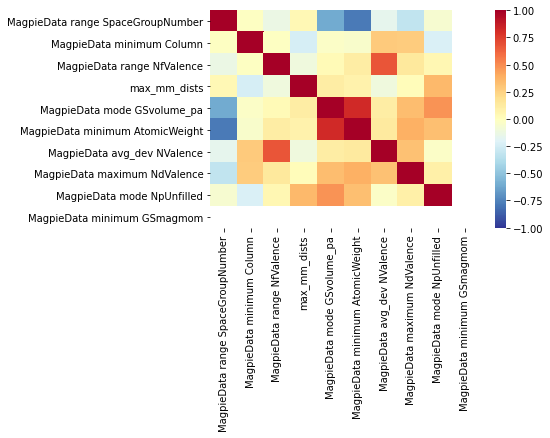

In [11]:
sns.heatmap(corr_df, vmin=-1, vmax=1, center=0, cmap="RdYlBu_r")

### See the correlation between the MendeleevNumber features

In [12]:
mendeleev_df = df_raw.filter(like="MendeleevNumber", axis=1)
mendeleev_df

,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,MagpieData avg_dev MendeleevNumber,MagpieData mode MendeleevNumber
0,9,85,76,73.470588,16.276817,85
1,9,83,74,59.400000,20.160000,61
2,9,83,74,59.000000,20.000000,60
3,9,83,74,58.600000,19.840000,59
4,9,85,76,73.941176,15.612457,85
...,...,...,...,...,...,...
399,46,87,41,73.333333,18.222222,87
400,12,87,75,66.200000,24.960000,87
401,12,87,75,73.400000,16.320000,87
402,12,87,75,66.800000,24.240000,87


In [13]:
mendeleev_df.corr()

,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,MagpieData avg_dev MendeleevNumber,MagpieData mode MendeleevNumber
MagpieData minimum MendeleevNumber,1.000000,0.076539,-0.995008,0.713954,-0.742074,-0.134779
MagpieData maximum MendeleevNumber,0.076539,1.000000,0.023346,0.079939,0.333570,0.327539
MagpieData range MendeleevNumber,-0.995008,0.023346,1.000000,-0.707858,0.777441,0.167922
MagpieData mean MendeleevNumber,0.713954,0.079939,-0.707858,1.000000,-0.871379,0.272556
MagpieData avg_dev MendeleevNumber,-0.742074,0.333570,0.777441,-0.871379,1.000000,0.048279
MagpieData mode MendeleevNumber,-0.134779,0.327539,0.167922,0.272556,0.048279,1.000000


<AxesSubplot:>

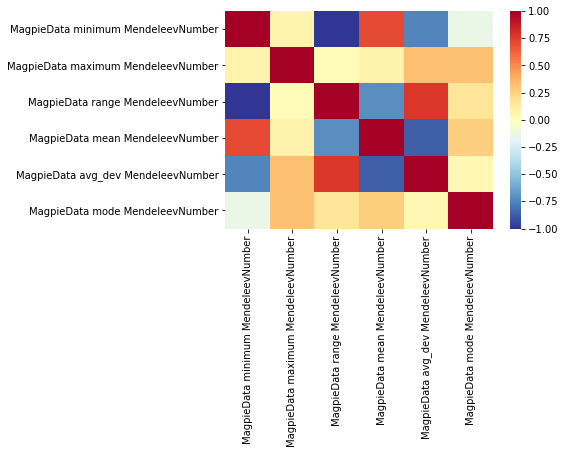

In [14]:
sns.heatmap(mendeleev_df.corr(), vmin=-1, vmax=1, center=0, cmap="RdYlBu_r")

### See the correlation between average deviation of covalent radius and electronegativity

In [15]:
cr_en_df = df_raw[["MagpieData avg_dev CovalentRadius", "MagpieData avg_dev Electronegativity"]]

In [16]:
cr_en_df.corr()

,MagpieData avg_dev CovalentRadius,MagpieData avg_dev Electronegativity
MagpieData avg_dev CovalentRadius,1.000000,0.919045
MagpieData avg_dev Electronegativity,0.919045,1.000000


# Data cleaning workflow

## 1. Remove rows with more than 6 NaN values

In [17]:
df_processed = remove_nullrows(df_raw, 6)

In [18]:
df_processed.shape[0] - df_raw.shape[0]

-1

We can see that we only dropped 1 row after this step, which is SiO$_2$.

## 2. Impute the missing values with the [KNNImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html)

For each row with missing values, we find its 5 nearest neighbors based on columns that are not missing. Then we impute the missing values using the values from the 5 nearest neighbors weighted by their distance to this row.

In [19]:
df_processed = knn_imputation(df_processed, weights="distance")

We can also confirm if all the missing values are indeed filled with mean values.

In [20]:
pd.DataFrame(df_processed.isna().sum(), columns=["num_na"])[columns_na_info.num_na != 0]

,num_na
gii,0
max_mm_dists,0
min_mm_dists,0
avg_mm_dists,0
max_mx_dists,0
min_mx_dists,0
avg_mx_dists,0
v_m,0
v_x,0
iv,0


## 3. Rename the columns for easier readability and plotting

In the heatmap, you might see that there are feautures with a "MagpieData" prefix. This step delete all those prefixes from the variable names and fill the white space with underscore.

In [21]:
df_processed = abbreviate_features(df_processed)

## 4. Remove columns with zero variance and high correlations

In [22]:
df_processed = remove_redundant_features(df_processed)

In [23]:
df_processed.shape[1] - df_raw.shape[1]

-58

Just by removing the zero-variance & highly correlated columns, we reduce the number of columns by 58, which leaves us with 106 features.

Now that we have **343** compounds, we can also check the number of compounds for each class after cleaning.

In [24]:
df_processed.Label.value_counts()

1    179
0     96
2     68
Name: Label, dtype: int64

## 5. Save the processed dataset

In [25]:
df_processed.to_excel(SAVE_PATH, index=False)
df_processed

,Compound,Label,struct_file_path,range_MendeleevNumber,mean_MendeleevNumber,avg_dev_MendeleevNumber,maximum_AtomicWeight,range_AtomicWeight,mean_AtomicWeight,avg_dev_AtomicWeight,...,avg_mx_dists,max_xx_dists,min_xx_dists,avg_xx_dists,v_m,v_x,iv_p1,est_hubbard_u,est_charge_trans,volume_per_site
0,Ba(FeSb3)4,0,../data/Structures/Metals/BaFe4Sb12_CollCode_6...,76.0,73.470588,16.276817,137.32700,81.482000,107.166294,24.151197,...,2.596481,3.450762,2.871024,3.266718,-23.735803,9.622199,54.91000,21.129322,19.456528,22.917528
1,Ba(NiP)2,0,../data/Structures/Metals/BaNi2P2_SD_1701656.cif,74.0,59.400000,20.160000,137.32700,106.353238,63.332265,29.597894,...,2.259574,3.709116,3.554335,3.631725,-22.390084,28.414957,35.18700,11.858755,35.445979,18.414152
2,Ba(PIr)2,0,../data/Structures/Metals/BaIr2P2_CollCode_957...,74.0,59.000000,20.000000,192.21700,161.243238,116.741705,68.614354,...,2.355169,3.794974,3.713769,3.754372,-20.210211,27.763527,28.00000,5.839285,34.042180,19.575756
3,Ba(PRh)2,0,../data/Structures/Metals/BaRh2P2_CollCode_501...,74.0,58.600000,19.840000,137.32700,106.353238,81.017105,40.034674,...,2.346291,3.776568,3.737587,3.757078,-20.397126,27.833127,31.06000,7.810114,33.195560,19.512571
4,Ba(Sb3Os)4,0,../data/Structures/Metals/BaOs4Sb12_CollCode_6...,76.0,73.941176,15.612457,190.23000,68.470000,138.786294,24.208803,...,2.635420,3.502512,2.914080,3.315708,-23.385103,9.480030,41.00000,12.916563,10.425350,23.964132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,VO2,2,../data/Structures/MIT_materials/HighT/VO2_HT_...,41.0,73.333333,18.222222,50.94150,34.942100,27.646767,15.529822,...,1.927294,2.725617,2.575183,2.675472,-45.333235,26.337259,65.28165,14.484546,9.779242,9.863262
339,YCoO3,2,../data/Structures/MIT_materials/HighT/YCoO3_C...,75.0,66.200000,24.960000,88.90585,72.906450,39.167449,27.801659,...,1.933264,3.133313,2.699880,2.788723,-37.430821,24.043918,51.27000,13.886580,12.815560,10.252012
340,YFe4(CuO4)3,2,../data/Structures/MIT_materials/HighT/YCu3Fe4...,75.0,73.400000,16.320000,88.90585,72.906450,34.745832,22.495719,...,2.356918,2.896772,2.559157,2.745188,-26.680740,24.867599,37.86795,12.807177,16.608178,9.756232
341,YNiO3,2,../data/Structures/MIT_materials/HighT/YNiO3_6...,75.0,66.800000,24.240000,88.90585,72.906450,39.119490,27.744108,...,1.963601,3.184308,2.736503,2.827539,-36.802534,23.821848,54.92000,15.898371,10.393278,10.686816
